## Sentiment Analyisis and Topic Modeling for Tweeter Data

### Helper Functions

#### A. Stemmer

In [2]:
from nltk.stem import PorterStemmer

In [3]:
stemmer = PorterStemmer()

In [4]:
def get_stem_word(text: str) -> str:
    
    stemmed_words = []
    sent_list = text.split()
    
    for word in sent_list:
        try:
            stemmed_words.append(stemmer.stem(word)) 
        except:
             stemmed_words.append(word)
    return ' '.join(stemmed_words)

#### B. Reader

In [5]:
# path for the cleaned data we are going to use
CLEANED_SAVE_PATH = "../cleaned_tweet_data.csv"

In [6]:
# taking a csv file path and reading a dataframe

def read_proccessed_data(csv_path: str):
    try:    
        df = pd.read_csv(csv_path)
        print("file read as csv")
        return df
    
    except FileNotFoundError:
        print("file not found")

### A. Sentiment Analyisis

In [7]:
import pandas as pd
from wordcloud import STOPWORDS,WordCloud

In [8]:
# reading the data

df = read_proccessed_data(CLEANED_SAVE_PATH)

file read as csv


In [9]:
# inspecting the columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6532 entries, 0 to 6531
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   created_at          6532 non-null   object 
 1   source              6532 non-null   object 
 2   original_text       6532 non-null   object 
 3   polarity            6532 non-null   float64
 4   subjectivity        6532 non-null   float64
 5   lang                6532 non-null   object 
 6   favorite_count      6532 non-null   int64  
 7   retweet_count       6532 non-null   float64
 8   original_author     6532 non-null   object 
 9   followers_count     6532 non-null   int64  
 10  friends_count       6532 non-null   int64  
 11  possibly_sensitive  6532 non-null   float64
 12  hashtags            3405 non-null   object 
 13  user_mentions       2721 non-null   object 
 14  place               6532 non-null   object 
 15  clean_text          6530 non-null   object 
dtypes: flo

In [10]:
# inspecting the polarity column
df['polarity']
df['polarity'].value_counts()


 0.000000    1829
-0.750000     501
 0.500000     210
 0.133333     202
 0.337500     189
             ... 
 0.518182       1
-0.060000       1
 0.096591       1
 0.260000       1
-0.292857       1
Name: polarity, Length: 380, dtype: int64

In [11]:
# checking if there are null values
text_null_sum = df['clean_text'].isnull().sum()
polarity_null_sum = df['polarity'].isnull().sum()

print(f'sum of null values in clean_text column: {text_null_sum}')
print(f'sum of null values in polarity cloumn: {polarity_null_sum}')

sum of null values in clean_text column: 2
sum of null values in polarity cloumn: 0


#### A.1 Data preparation for Sentiment Analysis



In [12]:
# creating cleanedTweet dataframe
cleanedTweet = pd.DataFrame(columns=['clean_text','polarity'])

cleanedTweet['clean_text'] = df['clean_text']
cleanedTweet['polarity'] = df['polarity']
cleanedTweet.dropna(inplace=True)

In [13]:
cleanedTweet

,clean_text,polarity
0,"africa is ""in the midst of a full-blown third ...",0.166667
1,dr moeti is head of who in africa and one of t...,0.133333
2,thank you for creating this amazing campaign ...,0.316667
3,former pfizer vp and virologist dr michael yea...,0.086111
4,i think it s important that we don t sell cova...,0.280000
...,...,...
6527,rt : zweli please just release the graphic des...,0.000000
6528,former pfizer vp and virologist dr michael yea...,0.086111
6529,respectfully veterinarians have to have a broa...,0.281250
6530,"""africa needs millions more doses here &amp; n...",0.125000


In [14]:
# takes polarity and returns a string either postive, negative or neutral

def text_category(p: float) -> str:
    if p > 0:
        return "positive"
    elif p == 0:
        return "neutral"
    else:
        return "negative"

In [15]:
# creating score column by applying text_category
cleanedTweet['score'] = cleanedTweet['polarity'].apply(text_category)
cleanedTweet['score'].value_counts()

positive    3426
neutral     1827
negative    1277
Name: score, dtype: int64

#### A.2 Looking into the prepared data for sentiment analysis

In [16]:

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from joblib import dump, load # used for saving and loading sklearn objects
from scipy.sparse import save_npz, load_npz # used for saving and loading sparse matrices
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split

<AxesSubplot:title={'center':'score'}>

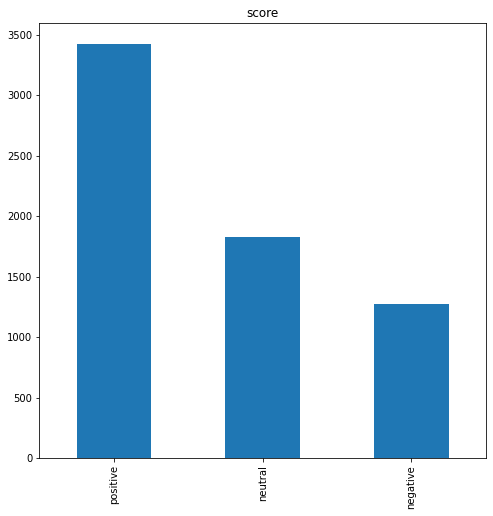

In [17]:
# Grouping the scores and plotting bar graph
score_count =  cleanedTweet['score'].value_counts()
score_count.plot(kind="bar", y="score", title="score", figsize=[8, 8])

<AxesSubplot:title={'center':'score'}, ylabel='score'>

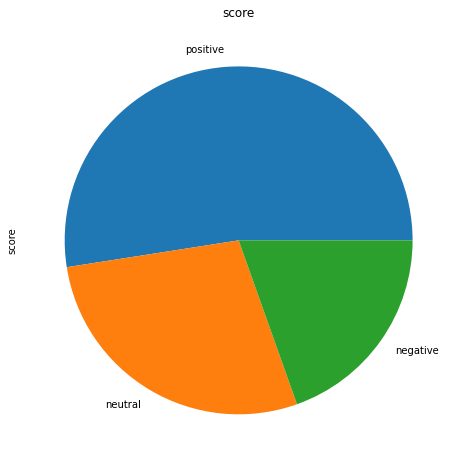

In [18]:
score_count.plot(kind="pie", y="score", title="score", x="", figsize=[8, 8])


In [19]:
# takes a string and returns if a value is "neutral"
def remove_neutral(value):
    return value != "neutral"

In [20]:
# creating score_map column
# we remove all rows that have neutral score
# then create a score_map. if score is "positive" it has value 1 else 0

cleanedTweet = cleanedTweet[cleanedTweet['score'].map(remove_neutral)]
cleanedTweet['score_map'] = cleanedTweet["score"].map( lambda score: 1 if score == "positive" else 0)


<ipython-input-20-6621b22335ef>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleanedTweet['score_map'] = cleanedTweet["score"].map( lambda score: 1 if score == "positive" else 0)


In [21]:
# transforming clean_tex bygetting the root word of clean_text words using Stemming
cleanedTweet['clean_text'] = cleanedTweet['clean_text'].apply(get_stem_word)


<ipython-input-21-c0833608cef5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleanedTweet['clean_text'] = cleanedTweet['clean_text'].apply(get_stem_word)


In [22]:
# separating our input and output
(X, y) = cleanedTweet['clean_text'], cleanedTweet['score_map']

In [23]:
# creating CountVectorizer and fitting it
trigram_vectorizer = CountVectorizer(ngram_range=(1, 3))
trigram_vectorizer.fit(X.values)


CountVectorizer(ngram_range=(1, 3))

In [24]:
# creating a tri_gram Vector representation for X
X_trigram = trigram_vectorizer.transform(X.values)

In [25]:
# creating a trigram tfidf transformer
trigram_tf_idf_transformer = TfidfTransformer()
trigram_tf_idf_transformer.fit(X_trigram)

TfidfTransformer()

In [26]:
# creating a tfidf representation of x
X_train_tf_idf = trigram_tf_idf_transformer.transform(X_trigram)

#### A.3 Model Training for sentiment analysis

In [27]:
# takes input as X, and ouput as Y, title of model as title
# split the input to train and valid
# use Stochastic Gradient Descent Classifier
# train
# out put the training score and validation score
def train_and_show_scores(X, y, title: str) -> None:
    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y, train_size=0.75, stratify=y
    )

    clf = SGDClassifier()
    clf.fit(X_train, y_train)
    train_score = clf.score(X_train, y_train)
    valid_score = clf.score(X_valid, y_valid)
    print(f'{title}\nTrain score: {round(train_score, 2)} ; Validation score: {round(valid_score, 2)}\n')

In [28]:
# train using inputs vectorized as trigram

train_and_show_scores(X_trigram, y, title="trigram")

trigram
Train score: 1.0 ; Validation score: 0.96



In [29]:
# train using inputs vectorized as trigram_tfidf


train_and_show_scores(X_train_tf_idf, y, title="trigram_tf_idf")

trigram_tf_idf
Train score: 1.0 ; Validation score: 0.96



### B. Topic Modeling

In [30]:
# !pip3 install gensim

In [37]:
# importing packages

import string
import gensim
from gensim.models import CoherenceModel
from gensim import corpora
from pprint import pprint
import pyLDAvis
import pyLDAvis.gensim_models






In [40]:
# function that takes a string and remove stop words

def remove_stopwords(sent: str) -> str:
    sent_list = sent.split()
    return ' '.join([word for word in sent_list if word not in STOPWORDS])

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [41]:
'''
    This is a topic model generator
'''


class TopicModel:
    
    # Topic model instance takes a cleaned tweet data frame and number of topics
    def __init__(self, tweet_df: pd.DataFrame, num_of_topics: int, do_stemming = False):
        self.df = tweet_df
        self.num_of_topics = num_of_topics
        self.do_stemming = do_stemming
    
    # extract the data of the clean_text only
    def extract_text_df(self):
        self.df = pd.DataFrame(self.df['clean_text']) 
        
        return self.df
    
    
    # removing stop words from for our clean_text
    # removing panctuations
    
    def further_pre_process(self):
        
        self.df['clean_text']= df['clean_text'].apply(lambda x: str(x).translate(str.maketrans(' ', ' ', string.punctuation))) 
        
        self.df['clean_text'] = self.df['clean_text'].apply(remove_stopwords)
        
        return self.df
    
    # preparing inputs to be trained
    # creating a sentence list from the clean_text column
    # getting root word by stemming sentences if stemming is True
    # changing each sentence into a list of words
    # creating a mapping from word to int
    # representing the sentences using the word id mapping
    def prepare_inputs(self, stemming=False):
        
        df = self.extract_text_df()
        df = self.further_pre_process()
        
        sentence_list = [text for text in self.df['clean_text']]
        
        if (stemming):      
            sentence_list = [get_stem_word(sentence) for sentence in sentence_list]
        
        word_list = [sent.split() for sent in sentence_list]
        word_to_int = corpora.Dictionary(word_list)
        
        corpus = [word_to_int.doc2bow(tweet) for tweet in word_list]
        
        return word_list, word_to_int, corpus
    
    
    # function that returns LDA_result to be visulazied
    def lda_prepared(self, lda_model, corpus,  word_list):
        pyLDAvis.enable_notebook()
        LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, word_list)
        return LDAvis_prepared
        
    
    # building the model
    # returns lda model and lda_model result to be visulazied
            
    def build(self, show_print=False):
        word_list, word_to_int, corpus = self.prepare_inputs(self.do_stemming)
        
        lda_model = gensim.models.ldamodel.LdaModel(
            corpus, id2word=word_to_int,num_topics=self.num_of_topics, 
            random_state=100, update_every=1, 
            chunksize=100, passes=10, alpha='auto',
            per_word_topics=True
        )
        
        lda_prepared = self.lda_prepared(lda_model, corpus, word_to_int)
        
        
        if show_print:
            pprint(lda_model.print_topics())
        
        return lda_model, lda_prepared
    
        
        

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### B.1 Topic Model building

In [42]:
# reading the cleaned data
df = read_proccessed_data(CLEANED_SAVE_PATH)

# creating an instance of topic model generator
tm = TopicModel(df, 8)

# model building
lda_model, lda_prepared =tm.build(show_print=True)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


file read as csv
[(0,
  '0.053*"covid19" + 0.032*"vaccines" + 0.023*"support" + 0.023*"amp" + '
  '0.021*"countries" + 0.021*"africa" + 0.019*"please" + 0.017*"south" + '
  '0.017*"government" + 0.016*"rich"'),
 (1,
  '0.038*"covid19" + 0.035*"vaccines" + 0.032*"help" + 0.029*"people" + '
  '0.028*"dont" + 0.025*"vaccine" + 0.025*"australia" + 0.023*"will" + '
  '0.019*"go" + 0.016*"doses"'),
 (2,
  '0.061*"vaccines" + 0.059*"covaxin" + 0.049*"0" + 0.044*"pmcg" + '
  '0.032*"dose2" + 0.020*"covid19" + 0.019*"vaccine" + 0.018*"people" + '
  '0.017*"medical" + 0.016*"days"'),
 (3,
  '0.097*"rt" + 0.086*"israel" + 0.085*"vaccines" + 0.071*"expired" + '
  '0.068*"another" + 0.066*"tried" + 0.066*"war" + 0.066*"liars" + '
  '0.066*"crime" + 0.066*"load"'),
 (4,
  '0.047*"s" + 0.033*"covid19" + 0.033*"vaccines" + 0.028*"one" + 0.024*"risk" '
  '+ 0.022*"vaccinated" + 0.018*"china" + 0.014*"less" + 0.014*"indian" + '
  '0.014*"graphic"'),
 (5,
  '0.039*"vaccines" + 0.037*"capacity" + 0.034*"a

In [43]:
lda_prepared

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.097026  0.162001       1        1  20.891795
1      0.046701 -0.131040       2        1  15.895585
7      0.279378  0.101146       3        1  13.685014
0      0.111302  0.025912       4        1  12.413266
4     -0.105702 -0.200947       5        1  10.701581
6     -0.029678 -0.109745       6        1   9.342092
3     -0.293203  0.261939       7        1   9.206277
2     -0.105825 -0.109266       8        1   7.864390, topic_info=         Term         Freq        Total Category  logprob  loglift
219     india  1583.000000  1583.000000  Default  30.0000  30.0000
205        rt  1067.000000  1067.000000  Default  29.0000  29.0000
456    israel   911.000000   911.000000  Default  28.0000  28.0000
455   expired   758.000000   758.000000  Default  27.0000  27.0000
128   another   767.000000   767.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
40   vaccines   557.306255  4438.863150   Topic8  -2.7890   0.4678
196    people   162.464979   756.491912   Topic8  -4.0217   1.0046
104   vaccine   168.273171  1042.439306   Topic8  -3.9866   0.7191
64    covid19   177.377048  3461.762004   Topic8  -3.9339  -0.4284
74     pfizer    66.505042   140.971629   Topic8  -4.9149   1.7915

[348 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
660       8  0.997095         0
276       2  0.400058         1
276       4  0.592491         1
438       8  0.980578        14
637       1  0.996268      1845
...     ...       ...       ...
149       1  0.858009       yet
149       2  0.136716       yet
1204      5  0.985834     youre
1099      6  0.991610  zimbabwe
2730      5  0.996380     zweli

[373 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 2, 8, 1, 5, 7, 4, 3])